In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from label_legends.preprocess import load_test, transform, holdout
from label_legends.result import calculate_scores, get_experiment, load_predictions, client, get_current
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AutoConfig, EvalPrediction, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import json
import torch
import mlflow
import polars as pl
import logging
import time
import numpy as np

from label_legends.util import RESOURCE

logging.basicConfig(level=logging.INFO)

/home/lukas/Programming/uni/nlp-ie-label-legends/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
test = transform(load_test().collect())
val, tra = holdout()
tra = transform(tra)
val = transform(val)

device = "cuda"

/home/lukas/Programming/uni/nlp-ie-label-legends/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [4]:
MODEL_NAME = 'distilbert-base-uncased'
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
config = AutoConfig.from_pretrained(MODEL_NAME)
tokenizer =DistilBertTokenizer.from_pretrained(MODEL_NAME)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
class SexistDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]).to(device=device) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).to(device=device)
        return item

    def __len__(self):
        return len(self.labels)
    

train_texts = tra['text'].to_list()
train_labels = tra['label'].to_list()

val_texts = val['text'].to_list()
val_labels = val['label'].to_list()

test_texts = test['text'].to_list()
test_labels = test['label'].to_list()

train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors="pt",)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors="pt",)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors="pt",)

train_dataset = SexistDataset(train_encodings, train_labels)
val_dataset = SexistDataset(val_encodings, val_labels)
test_dataset = SexistDataset(test_encodings, test_labels)

In [6]:
def compute_metrics(pred: EvalPrediction):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    scores = calculate_scores(labels, preds)
    # precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    # acc = accuracy_score(labels, preds)
    return scores.asdict()

# Define the Training Arguments
training_args = TrainingArguments(
    output_dir='./results_distil',
    learning_rate=5e-5,
    per_device_train_batch_size=100 if device == "cuda" else 8,
    per_device_eval_batch_size=100 if device == "cuda" else 8,
    num_train_epochs=3,
    # weight_decay=0.01,
    logging_dir='./logs',
    dataloader_pin_memory=False if device == "cuda" else True,
    # save_total_limit=2,
    eval_strategy="epoch",
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='fscore',
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [7]:
start_time = time.time()
train_output = trainer.train()  # Returns a TrainOutput object
training_time_manual = time.time() - start_time
train_metrics = train_output.metrics  # Contains train_runtime, train_loss, etc.

# Assume trainer.evaluate() has been run and returned results
eval_results = trainer.evaluate()  # Contains eval_runtime, eval_accuracy, etc.

# Combine training and evaluation metrics
all_metrics = {**train_metrics, **eval_results}
metrics = {**eval_results}

# Create a Polars DataFrame
df = pl.DataFrame(metrics)
df

/tmp/ipykernel_1362532/4018420611.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]).to(device=device) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss


/tmp/ipykernel_1362532/4018420611.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]).to(device=device) for key, val in self.encodings.items()}


/tmp/ipykernel_1362532/4018420611.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]).to(device=device) for key, val in self.encodings.items()}


/tmp/ipykernel_1362532/4018420611.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]).to(device=device) for key, val in self.encodings.items()}


🏃 View run ./results_distil at: https://mlflow.mahluke.page/#/experiments/0/runs/1014ce752bda40a1aaba2a5be1c94463
🧪 View experiment at: https://mlflow.mahluke.page/#/experiments/0


/tmp/ipykernel_1362532/4018420611.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]).to(device=device) for key, val in self.encodings.items()}


eval_loss,eval_precision,eval_recall,eval_fscore,eval_accuracy,eval_tp,eval_tn,eval_fp,eval_fn,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
f64,f64,f64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64
0.356572,0.743793,0.69696,0.719616,0.861032,2247,8602,774,977,29.9618,420.536,4.205,3.0


In [8]:
start_time_test = time.time()
predicted_test = trainer.predict(test_dataset)
testing_time_manual = time.time() - start_time_test
print(testing_time_manual)

y_pred = predicted_test.predictions.argmax(-1)
y_true = predicted_test.label_ids

/tmp/ipykernel_1362532/4018420611.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]).to(device=device) for key, val in self.encodings.items()}


43.41483950614929


In [9]:
print(training_time_manual)

653.7506744861603


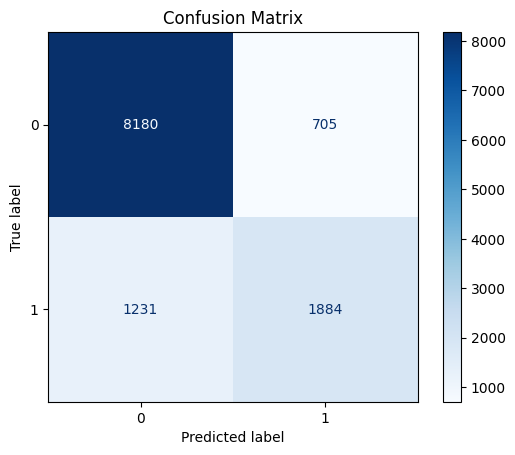

In [10]:

scores = calculate_scores(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=scores.confusion_matrix())
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()

In [12]:
print(scores)

precision:	0.7277
recall:		0.6048
fscore:		0.6606
accuracy:	0.8387
tn: 8180	 fp: 705
fn: 1231	 tp: 1884


In [13]:
mlflow.end_run()
with mlflow.start_run(
        experiment_id=get_experiment().experiment_id, 
        run_name="distilbert 3 epochs"
        ):
    mlflow.log_param("model_name", MODEL_NAME)
    mlflow.log_params(training_args.to_dict())

    mlflow.log_metrics(scores.asdict())
    mlflow.set_tag("model", "distilbert")

    mlflow.log_table({"id": test["id"], "prediction": y_pred}, "predictions.json")

    # Register the model
    model_uri = f"runs:/{mlflow.active_run().info.run_id}/predictions_distilbert.json"
    registered_model = mlflow.register_model(model_uri=model_uri, name="distilbert") 


client().set_registered_model_alias("distilbert", "current", registered_model.version)

🏃 View run likeable-penguin-521 at: https://mlflow.mahluke.page/#/experiments/0/runs/4bdbda98529f4f2eb862ee73763e366c
🧪 View experiment at: https://mlflow.mahluke.page/#/experiments/0


Registered model 'distilbert' already exists. Creating a new version of this model...


2024/12/15 22:40:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: distilbert, version 2


Created version '2' of model 'distilbert'.


🏃 View run distilbert 3 epochs at: https://mlflow.mahluke.page/#/experiments/769295261228132607/runs/876fb0d28126429fbd7c402e7f63722b
🧪 View experiment at: https://mlflow.mahluke.page/#/experiments/769295261228132607
